# **Central Theme: What is the impact of time and weather conditions on ride-hailing services in Boston?**


# Reading in the necessary libraries and data:

In [ ]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
df = pd.read_csv('uber_lyft.csv')
df.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,Unnamed: 55,Unnamed: 56
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,12/16/18 9:30,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,11/27/18 2:00,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,11/28/18 1:00,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,11/30/18 4:53,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,11/29/18 3:49,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
len(df)

60392

In [ ]:
df['name'].unique()

array(['Shared', 'Lux', 'Lyft', 'Lux Black XL', 'Lyft XL', 'Lux Black',
       'UberXL', 'Black', 'UberX', 'WAV', 'Black SUV', 'UberPool'],
      dtype=object)

In [ ]:
columns = df.columns
print(columns)

Index(['id', 'timestamp', 'hour', 'day', 'month', 'datetime', 'timezone',
       'source', 'destination', 'cab_type', 'product_id', 'name', 'price',
       'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime', 'Unnamed: 55',
       'U

In [ ]:
df.dtypes

id                              object
timestamp                      float64
hour                             int64
day                              int64
month                            int64
datetime                        object
timezone                        object
source                          object
destination                     object
cab_type                        object
product_id                      object
name                            object
price                          float64
distance                       float64
surge_multiplier               float64
latitude                       float64
longitude                      float64
temperature                    float64
apparentTemperature            float64
short_summary                   object
long_summary                    object
precipIntensity                float64
precipProbability              float64
humidity                       float64
windSpeed                      float64
windGust                 

# Ethan

What cab types (Uber or Lyft) are more popular during certain times of the day or under specific winter weather conditions?

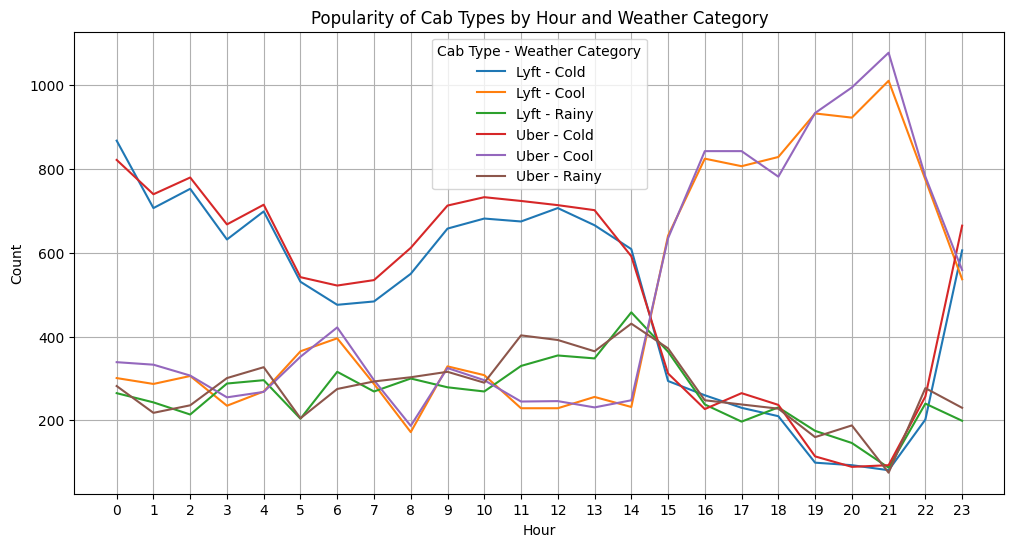

In [ ]:
1# Convert the 'timestamp' column to datetime format and create a new 'hour' column
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['hour'] = df['timestamp'].dt.hour

# Define a function to categorize weather conditions
def categorize_weather(row):
    if row['precipIntensity'] > 0:
        return 'Rainy'
    elif row['temperature'] < 40:  # Assuming temperature is in Fahrenheit
        return 'Cold'
    else:
        return 'Cool'

# Apply the function to create a new 'weather_category' column
df['weather_category'] = df.apply(categorize_weather, axis=1)

# Group by 'hour', 'weather_category', and 'cab_type' to find the count of each cab_type
popularity = df.groupby(['hour', 'weather_category', 'cab_type']).size().reset_index(name='count')

# Pivot the data for line plot
line_plot_data = popularity.pivot_table(index='hour', columns=['cab_type', 'weather_category'], values='count', fill_value=0)

# Sort columns by cab type and then by weather category
sorted_columns = sorted(line_plot_data.columns, key=lambda x: (x[0], x[1]))

# Plot the line plot
plt.figure(figsize=(12, 6))
for column in sorted_columns:
    plt.plot(line_plot_data.index, line_plot_data[column], label=f'{column[0]} - {column[1]}')
plt.title('Popularity of Cab Types by Hour and Weather Category')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.legend(title='Cab Type - Weather Category')
plt.xticks(range(0, 24))
plt.grid()
plt.show()

It appears that cab type has little to do with the popularity during certain times or weather conditions.

The same general behavior is exhibited for Lyft and Uber rides if it is cold, cool, and rainy. There are more rides when it is cold up until 2:30 PM, and then there are more rides when it is cool from 2:30 PM onward.

When it is cold, the number of rides decrease from 12AM - 7AM, then increase and level out till about 1PM, then sharply decline until 9PM before spiking up at 11 AM

When it is cool, the number of rides is incresses slightly from 4AM - 6AM, sharply decreases until 8AM, then rises and is relatively steady until 2PM, where rides spike until 4PM (but are still growing) before sharply declining at 9PM.

When it is rainy, there is no significant change; rides generally increase from 10AM - 2PM before declining steadily up until 9PM, where there is a small spike till 11AM.

Which cab type (Uber or Lyft) has a higher surge multiplier during peak hours?

In [ ]:
# Define morning and evening peak hours
morning_peak = (df['hour'] >= 7) & (df['hour'] <= 10)
evening_peak = (df['hour'] >= 17) & (df['hour'] <= 20)

# Filter the data to keep only morning and evening peak hours
morning_peak_data = df[morning_peak]
evening_peak_data = df[evening_peak]

# Group by 'cab_type' and calculate the average surge multiplier for morning peak hours
morning_average_surge = morning_peak_data.groupby('cab_type')['surge_multiplier'].mean()

# Group by 'cab_type' and calculate the average surge multiplier for evening peak hours
evening_average_surge = evening_peak_data.groupby('cab_type')['surge_multiplier'].mean()

print("Morning peak hours average surge multiplier:")
print(morning_average_surge)

print("\nEvening peak hours average surge multiplier:")
print(evening_average_surge)

# Problem - Uber only has a surge multiplier of 1 in the data set, so I do not think this question is worth pursuing/using

Morning peak hours average surge multiplier:
cab_type
Lyft    1.033519
Uber    1.000000
Name: surge_multiplier, dtype: float64

Evening peak hours average surge multiplier:
cab_type
Lyft    1.032116
Uber    1.000000
Name: surge_multiplier, dtype: float64


What is the average price difference between Uber and Lyft rides for the same distance and time of day?

    hour  price_difference
0      0          0.358573
1      1          2.922485
2      2          1.131556
3      3          2.885880
4      4         -1.466931
5      5          7.860632
6      6          0.986995
7      7         -0.469365
8      8          6.682277
9      9          1.905733
10    10          0.084564
11    11          1.733909
12    12          1.593827
13    13         -0.211582
14    14          0.197869
15    15         -0.231370
16    16         13.585239
17    17          1.119259
18    18          1.093677
19    19         -0.159365
20    20          3.713360
21    21         -0.148025
22    22         -0.328885
23    23          3.569621


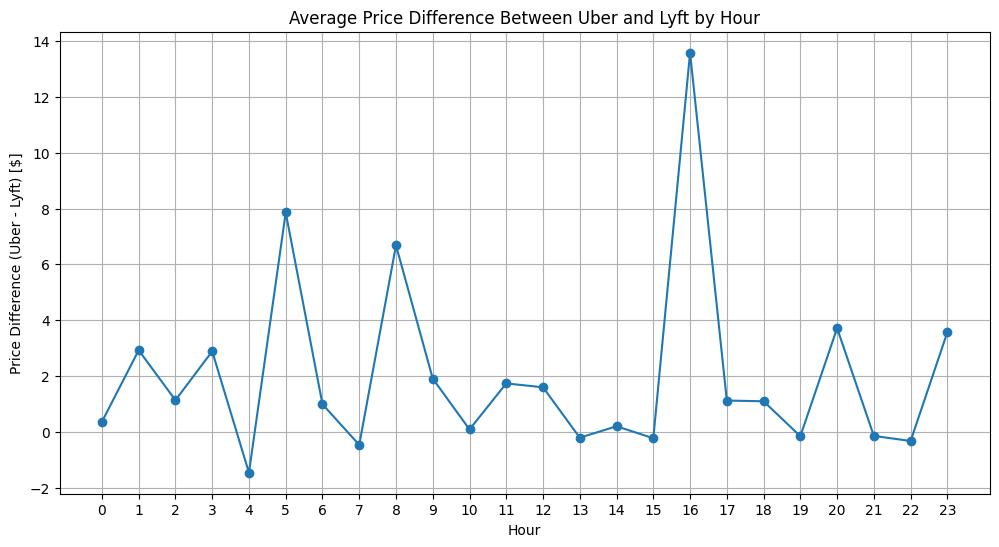

In [ ]:
# Create a new column representing the price per mile
df['price_per_mile'] = df['price'] / df['distance']

# Round the distance to the nearest mile for simplification
df['rounded_distance'] = df['distance'].round()

# Group by 'cab_type', 'hour', and 'rounded_distance' and calculate the average price per mile
average_price_per_mile = df.groupby(['cab_type', 'hour', 'rounded_distance'])['price_per_mile'].mean().reset_index()

# Pivot the data to have 'cab_type' as columns
pivoted_data = average_price_per_mile.pivot_table(index=['hour', 'rounded_distance'], columns='cab_type', values='price_per_mile').reset_index()

# Calculate the price difference between Uber and Lyft rides for the same distance and time of day
pivoted_data['price_difference'] = pivoted_data['Uber'] - pivoted_data['Lyft']

# Group by 'hour' and calculate the average price difference between Uber and Lyft
hourly_price_difference = pivoted_data.groupby('hour')['price_difference'].mean().reset_index()

# Print the average price difference for each hour
print(hourly_price_difference)

# Create line plot
plt.figure(figsize=(12, 6))
plt.plot(hourly_price_difference['hour'], hourly_price_difference['price_difference'], marker='o')

# Set plot labels and title
plt.xlabel('Hour')
plt.ylabel('Price Difference (Uber - Lyft) [$]')
plt.title('Average Price Difference Between Uber and Lyft by Hour')
plt.xticks(range(0, 24))
plt.grid()

# Display the plot
plt.show()

Even though the distance is not explicitly visualized in the final graph, it is taken into consideration during the calculations. The code calculates the price difference between Uber and Lyft rides for the same distance and time of day and then aggregates the results by hour. So, the final graph shows the average price difference between Uber and Lyft rides by hour, considering the same distance and time of day.

Positive values indicate that Uber is more expensive, while negative values indicate that Lyft is more expensive. This is because we calculated the price difference as pivoted_data['price_difference'] = pivoted_data['Uber'] - pivoted_data['Lyft']





# Makenzie

What is the most common price per mile to travel with a ride service?

price_per_mile
3.0               6209
6.0               6081
4.0               5939
5.0               4866
7.0               4824
dtype: int64


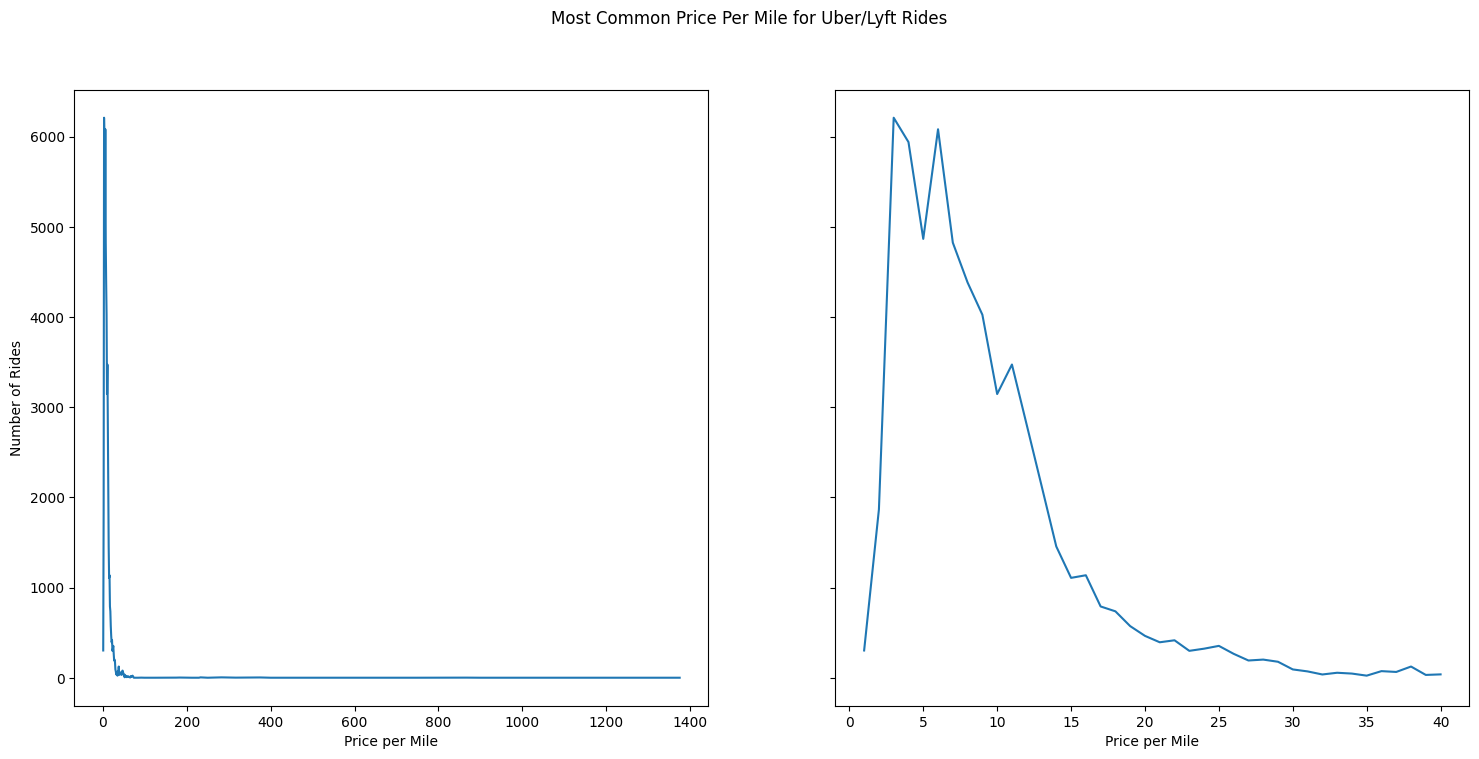

In [ ]:
# Create a figure space and specify they will be side-by-side
fig, (ax1, ax2) = subplots(nrows=1,
                         ncols=2,
                         sharey=True,
                         figsize=(18,8))

# Create a new column representing the price per mile
df['price_per_mile'] = df['price'] / df['distance']

# Round the price_per_model varaible and group by this price to determine the most common prices per mile
df['price_per_mile'].round().value_counts().sort_index().plot(ax=ax1)
ax1.set_xlabel('Price per Mile')
ax1.set_ylabel('Number of Rides')
plt.suptitle('Most Common Price Per Mile for Uber/Lyft Rides')

# Create the same plot but with only the top 40 values to make the graph more interpretable
df['price_per_mile'].round().value_counts().sort_index()[:40].plot(ax=ax2)
ax2.set_xlabel('Price per Mile')

# Return the top 5 prices that occur the most for Uber/Lyft rides
top_5_ppm = df[['price_per_mile']].round().value_counts().iloc[:5]
print(top_5_ppm)

# Display graph
plt.show()

The graph on the right shows that there is a large long tail for price per mile for Uber and Lyft rides that goes to nearly $1,400. The graph on the left is more interpretable and shows that the most common price per mile for ride services is from 3 to 7 dollars with a steady decline to about 30 dollars where the trend begins to flatten out to a much smaller portion of rides.

What is the distribution of price per mile throughout the day?

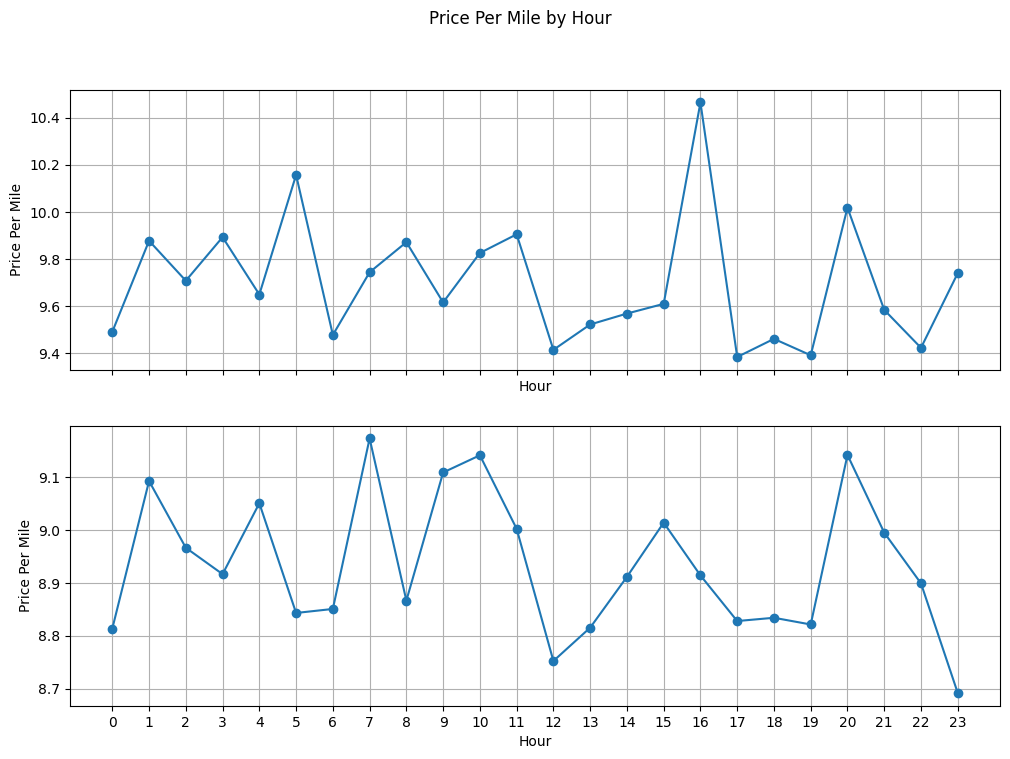

In [ ]:
# Create a figure space and specify the plots to be on top of each other
fig, (ax1, ax2) = subplots(nrows=2,
                         ncols=1,
                         sharex=True,
                         figsize=(12,8))

# Mask for price per mile rides that cost no more than $40 per mile
remove_outliers = (df['price_per_mile'].round() <= 40)
df_without_outliers = df[remove_outliers]

# Group by 'hour' and 'rounded_distance' and calculate the average price per mile
avg_ppm = df.groupby(['hour'])['price_per_mile'].mean().reset_index()
ax1.plot(avg_ppm['hour'], avg_ppm['price_per_mile'], marker='o')
# Set plot labels and title
ax1.set_xlabel('Hour')
ax1.set_ylabel('Price Per Mile')
ax1.grid()

# Same grouping and graph but without price per mile outliers
avg_ppm = df_without_outliers.groupby(['hour'])['price_per_mile'].mean().reset_index()
ax2.plot(avg_ppm['hour'], avg_ppm['price_per_mile'], marker='o')
# Set plot labels and title
ax2.set_xlabel('Hour')
ax2.set_ylabel('Price Per Mile')
ax2.grid()

plt.suptitle('Price Per Mile by Hour')
plt.xticks(range(0, 24))

# Display the plot
plt.show()

Both graphs show that there is a relatively small range of variety for price per mile throughout the day. The graph with outliers included shows the range of price per mile throughout the day is a little over a $1, whereas the graph without outliers shows a range of only about 5 cents per mile throughout the day.

# Ashley

What are the most common pickup and dropoff locations for Uber and Lyft rides? Do the top locations differ between the two services?

In [ ]:
import matplotlib.pyplot as plt
df = pd.read_csv('uber_lyft.csv')

Pickup Locations

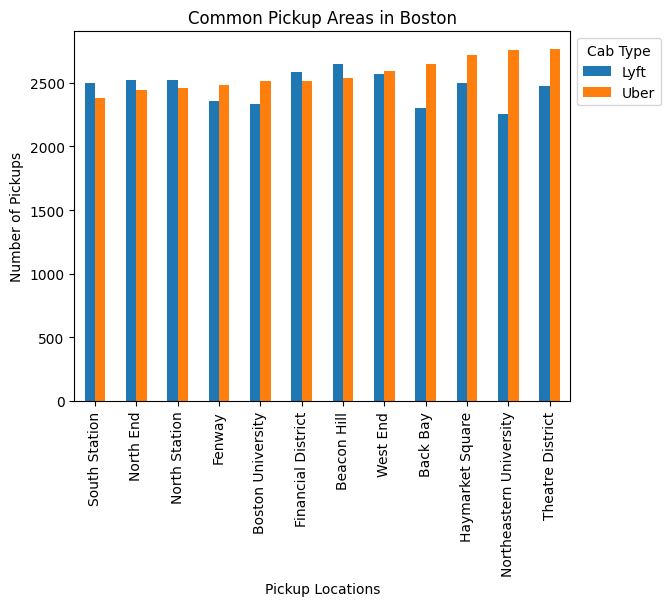

In [ ]:
pickup = df[['source', 'cab_type']].value_counts().unstack().sort_values('Uber')
pickup
pickup.plot.bar()

plt.xlabel("Pickup Locations")
plt.ylabel("Number of Pickups")
plt.title("Common Pickup Areas in Boston")
plt.legend(title='Cab Type', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [ ]:
df['source'].value_counts()

Theatre District           5242
Haymarket Square           5216
Beacon Hill                5188
West End                   5161
Financial District         5101
Northeastern University    5012
North Station              4984
North End                  4973
Back Bay                   4951
South Station              4876
Boston University          4852
Fenway                     4836
Name: source, dtype: int64

In [ ]:
pickup.sort_values('Uber', ascending = False)

cab_type,Lyft,Uber
source,,
Theatre District,2476,2766
Northeastern University,2252,2760
Haymarket Square,2501,2715
Back Bay,2300,2651
West End,2569,2592
Beacon Hill,2647,2541
Financial District,2583,2518
Boston University,2335,2517
Fenway,2355,2481


In [ ]:
pickup.sort_values('Lyft', ascending = False)

cab_type,Lyft,Uber
source,,
Beacon Hill,2647,2541
Financial District,2583,2518
West End,2569,2592
North End,2526,2447
North Station,2525,2459
Haymarket Square,2501,2715
South Station,2496,2380
Theatre District,2476,2766
Fenway,2355,2481


Overall, North Station, Theatre District, and Fenway are the top three most common pick up areas.

The top locations differ between the two services.

For Uber, the top three pickup locations are:

1. Back Bay
2. North End
3. Fenway

For Lyft, the top three pickup locations are:

1. North Station
2. Theatre District
3. Beacon Hill

Dropoff Locations

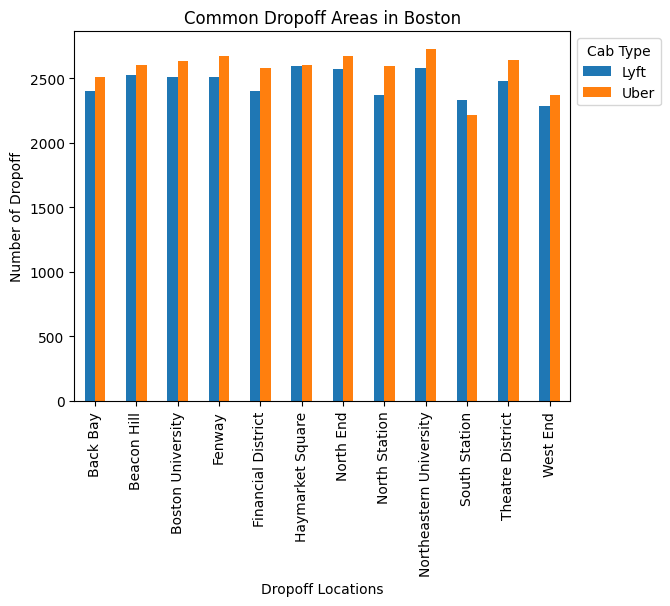

In [ ]:
dropoff = df[['destination', 'cab_type']].value_counts().unstack()
dropoff
dropoff.plot.bar()

plt.xlabel("Dropoff Locations")
plt.ylabel("Number of Dropoff")
plt.title("Common Dropoff Areas in Boston")
plt.legend(title='Cab Type', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [ ]:
df['destination'].value_counts()

Northeastern University    5308
North End                  5245
Haymarket Square           5194
Fenway                     5184
Boston University          5147
Theatre District           5125
Beacon Hill                5123
Financial District         4984
North Station              4971
Back Bay                   4912
West End                   4650
South Station              4549
Name: destination, dtype: int64

In [ ]:
dropoff.sort_values('Uber', ascending = False)

cab_type,Lyft,Uber
destination,,
Northeastern University,2581,2727
North End,2572,2673
Fenway,2512,2672
Theatre District,2480,2645
Boston University,2510,2637
Haymarket Square,2592,2602
Beacon Hill,2523,2600
North Station,2374,2597
Financial District,2405,2579


In [ ]:
dropoff.sort_values('Lyft', ascending = False)

cab_type,Lyft,Uber
destination,,
Haymarket Square,2592,2602
Northeastern University,2581,2727
North End,2572,2673
Beacon Hill,2523,2600
Fenway,2512,2672
Boston University,2510,2637
Theatre District,2480,2645
Financial District,2405,2579
Back Bay,2400,2512


Overall, North End, Northeastern University, and Fenway are the top three most common dropoff areas.

The top locations differ between the two services.

For Uber, the top three dropoff locations are:

1. North End
2. Northeastern University
3. Fenway

For Lyft, the top three dropoff locations are:

1. South Station
2. Haymarket Square
3. North End

# Enrique

How do price comparisons between Uber and Lyft change as the week progresses? Do prices tend to rise over the weekend?

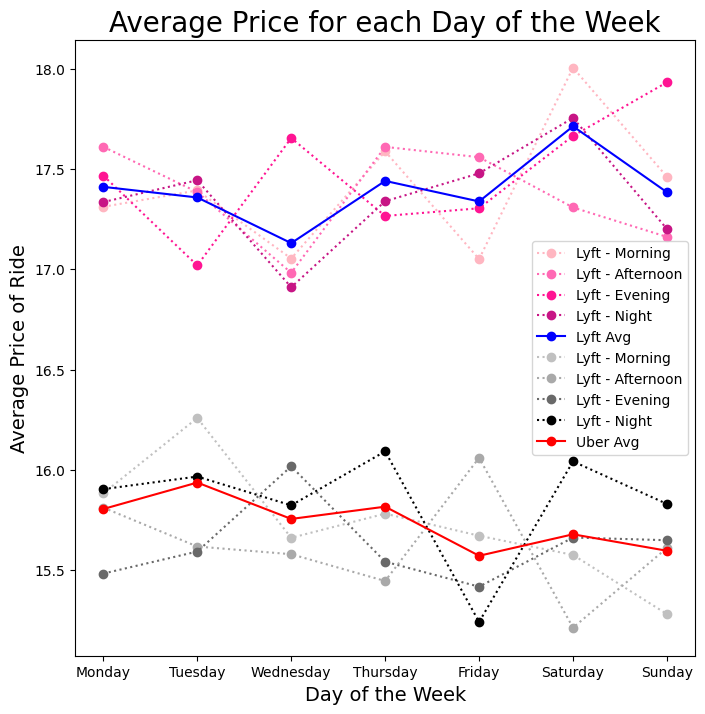

In [ ]:
df = pd.read_csv('uber_lyft.csv')
df['datetime'] = pd.to_datetime(df["datetime"])
df['daynumber'] = df['datetime'].dt.dayofweek
def get_day_of_week(s):
    if s == 0:
        day = 'Monday'
    elif s == 1:
        day = 'Tuesday'
    elif s == 2:
        day = 'Wednesday'
    elif s == 3:
        day = 'Thursday'
    elif s == 4:
        day = 'Friday'
    elif s == 5:
        day = 'Saturday'
    elif s == 6:
        day = 'Sunday'
    return day

def get_part_of_day(s):

    if s.hour in [5, 6, 7, 8, 9, 10, 11]:
        part = "Morning"
    elif s.hour in [12, 13, 14, 15, 16]:
        part = "Afternoon"
    elif s.hour in [17, 18, 19, 20]:
        part = "Evening"
    elif s.hour in [21, 22, 23, 24, 0, 1, 2, 3, 4]:
        part = "Night"
    return part

df["dayofweek"] = df["daynumber"].map(get_day_of_week)
df["partofday"] = df["datetime"].map(get_part_of_day)

df2 = df.groupby(["partofday", "dayofweek", "cab_type"])[["price"]].mean().reset_index()
df2["dayofweek"] = pd.Categorical(df2['dayofweek'], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
df2["partofday"] = pd.Categorical(df2['partofday'], ["Morning", "Afternoon", "Evening", "Night"])
df2.sort_values(["dayofweek", "partofday"], inplace = True)

df3 = df.groupby(["dayofweek", "cab_type"])[["price"]].mean().reset_index()
df3["dayofweek"] = pd.Categorical(df3['dayofweek'], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
df3.sort_values("dayofweek", inplace = True)

lyft_cab = df3[df3['cab_type'] == "Lyft"]

lyft_cab_morning = df2[(df2['cab_type'] == "Lyft") & (df2["partofday"] == "Morning")]
lyft_cab_afternoon = df2[(df2['cab_type'] == "Lyft") & (df2["partofday"] == "Afternoon")]
lyft_cab_evening = df2[(df2['cab_type'] == "Lyft") & (df2["partofday"] == "Evening")]
lyft_cab_night = df2[(df2['cab_type'] == "Lyft") & (df2["partofday"] == "Night")]

uber_cab_morning = df2[(df2['cab_type'] == "Uber") & (df2["partofday"] == "Morning")]
uber_cab_afternoon = df2[(df2['cab_type'] == "Uber") & (df2["partofday"] == "Afternoon")]
uber_cab_evening = df2[(df2['cab_type'] == "Uber") & (df2["partofday"] == "Evening")]
uber_cab_night = df2[(df2['cab_type'] == "Uber") & (df2["partofday"] == "Night")]
uber_cab = df3[df3['cab_type'] == "Uber"]

fig, (ax1) = subplots(nrows=1,
                           ncols=1,
                           sharey=True,
                           figsize=(8, 8))

plot(lyft_cab_morning['dayofweek'], lyft_cab_morning['price'], marker='o', linestyle='dotted', label='Lyft - Morning', color = "lightpink")
plot(lyft_cab_afternoon['dayofweek'], lyft_cab_afternoon['price'], marker='o', linestyle='dotted', label='Lyft - Afternoon', color = "hotpink")
plot(lyft_cab_evening['dayofweek'], lyft_cab_evening['price'], marker='o', linestyle='dotted', label='Lyft - Evening', color = "deeppink")
plot(lyft_cab_night['dayofweek'], lyft_cab_night['price'], marker='o', linestyle='dotted', label='Lyft - Night', color = "mediumvioletred")

plot(lyft_cab['dayofweek'], lyft_cab['price'], marker='o', linestyle='solid', label='Lyft Avg', color = "blue")

plot(uber_cab_morning['dayofweek'], uber_cab_morning['price'], marker='o', linestyle='dotted', label='Lyft - Morning', color = "silver")
plot(uber_cab_afternoon['dayofweek'], uber_cab_afternoon['price'], marker='o', linestyle='dotted', label='Lyft - Afternoon', color = "darkgrey")
plot(uber_cab_evening['dayofweek'], uber_cab_evening['price'], marker='o', linestyle='dotted', label='Lyft - Evening', color = "dimgray")
plot(uber_cab_night['dayofweek'], uber_cab_night['price'], marker='o', linestyle='dotted', label='Lyft - Night', color = "k")

plot(uber_cab['dayofweek'], uber_cab['price'], marker='o', linestyle='solid', label='Uber Avg', color = "red")

title("Average Price for each Day of the Week", fontdict={'fontsize':20})
xlabel('Day of the Week', fontdict={'fontsize':14})
ylabel('Average Price of Ride', fontdict={'fontsize':14})
legend(loc='best')
show()

Does the weather (rain) affect the distance that people are willing to travel on a ride sharing app? Does weather affect the popularity of rides overall?

Text(0.5, 0.98, 'Number of Rides v. Distance Histogram Seperated by Rain and No Rain')

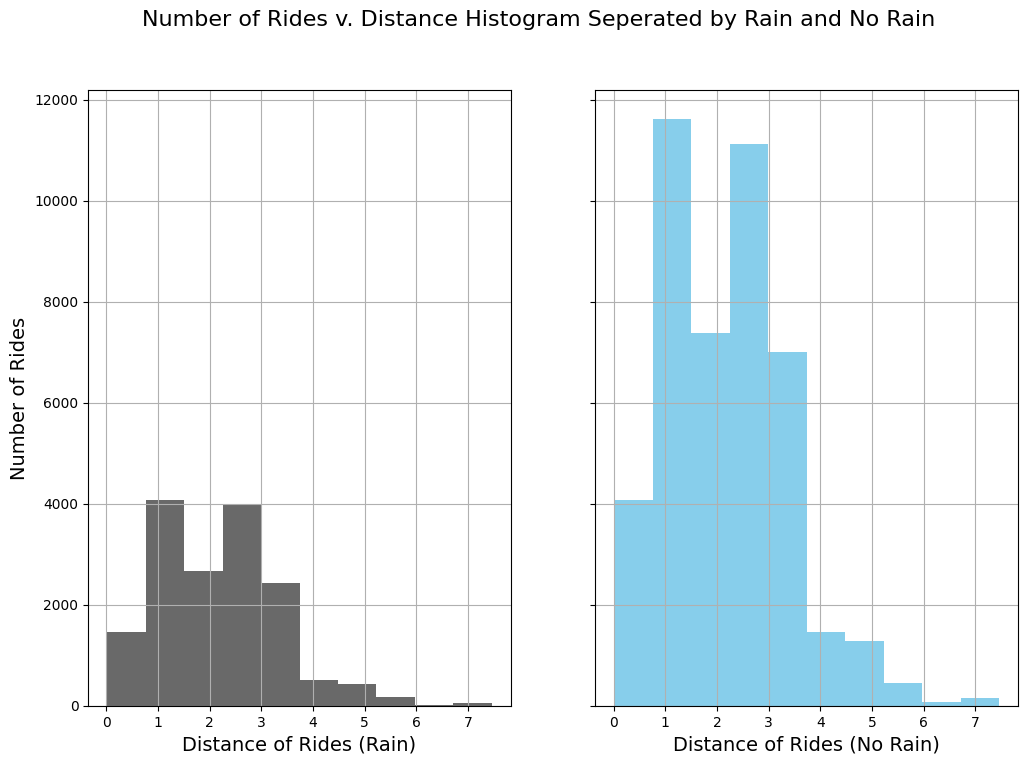

In [ ]:
df[["partofday","long_summary", "precipIntensity", "distance", "icon"]]

dfrainmorning = df[(df["partofday"] == "Morning") &\
   ((df["long_summary"] == ' Rain throughout the day. ')\
    | (df["long_summary"] == ' Rain until morning, starting again in the evening. ')\
   | (df["long_summary"] == ' Light rain in the morning. ')\
   | (df["long_summary"] == ' Light rain in the morning and overnight. ')\
   | (df["long_summary"] == ' Rain in the morning and afternoon. ')\
   | (df["long_summary"] == ' Light rain until evening. '))]\
[["partofday", "long_summary", "distance", "icon"]]

dfnorainmorning = df[(df["partofday"] == "Morning") &\
   ((df["long_summary"] != ' Rain throughout the day. ')\
    & (df["long_summary"] != ' Rain until morning, starting again in the evening. ')\
   & (df["long_summary"] != ' Light rain in the morning. ')\
   & (df["long_summary"] != ' Light rain in the morning and overnight. ')\
   & (df["long_summary"] != ' Rain in the morning and afternoon. ')\
   & (df["long_summary"] != ' Light rain until evening. '))]\
[["partofday", "long_summary", "distance", "icon"]]

dfrainafternoon = df[(df["partofday"] == "Afternoon") &\
   ((df["long_summary"] == ' Rain throughout the day. ')\
   | (df["long_summary"] == ' Rain in the morning and afternoon. ')\
   | (df["long_summary"] == ' Light rain until evening. '))]\
[["partofday", "long_summary", "distance", "icon"]]

dfnorainafternoon = df[(df["partofday"] == "Afternoon") &\
   ((df["long_summary"] != ' Rain throughout the day. ')\
   & (df["long_summary"] != ' Rain in the morning and afternoon. ')\
   & (df["long_summary"] != ' Light rain until evening. '))]\
[["partofday", "long_summary", "distance", "icon"]]

dfrainevening = df[(df["partofday"] == "Evening") &\
   ((df["long_summary"] == ' Rain throughout the day. ')\
   | (df["long_summary"] == ' Rain until morning, starting again in the evening. ')\
   | (df["long_summary"] == ' Light rain until evening. '))]\
[["partofday", "long_summary", "distance", "icon"]]

dfnorainevening = df[(df["partofday"] == "Evening") &\
   ((df["long_summary"] != ' Rain throughout the day. ')\
   & (df["long_summary"] != ' Rain until morning, starting again in the evening. ')\
   & (df["long_summary"] != ' Light rain until evening. '))]\
[["partofday", "long_summary", "distance", "icon"]]

dfrainnight = df[(df["partofday"] == "Night") &\
   ((df["long_summary"] == ' Rain until morning, starting again in the evening. ')\
   | (df["long_summary"] == ' Light rain in the morning and overnight. ')\
   | (df["long_summary"] == ' Rain throughout the day. '))]\
[["partofday", "long_summary", "distance", "icon"]]

dfnorainnight = df[(df["partofday"] == "Night") &\
   ((df["long_summary"]!= ' Rain until morning, starting again in the evening. ')\
   & (df["long_summary"] != ' Light rain in the morning and overnight. ')\
   & (df["long_summary"] != ' Rain throughout the day. '))]\
[["partofday", "long_summary", "distance", "icon"]]

rainframes = [dfrainmorning, dfrainafternoon, dfrainevening, dfrainnight]
allrain = pd.concat(rainframes)
norainframes = [dfnorainmorning, dfnorainafternoon, dfnorainevening, dfnorainnight]
allnorain = pd.concat(norainframes)

fig, (ax1, ax2) = subplots(nrows=1,
                           ncols=2,
                           sharey=True,
                           figsize=(12, 8))

# Plot the rain histogram on the first subplot
allrain["distance"].hist(ax = ax1, color = "dimgray")
ax1.set_xlabel('Distance of Rides (Rain)', fontdict={'fontsize':14})
ax1.set_ylabel('Number of Rides', fontdict={'fontsize':14})

# Plot the no rain histogram on the second subplot
allnorain["distance"].hist(ax = ax2, color = "skyblue")
ax2.set_xlabel('Distance of Rides (No Rain)', fontdict={'fontsize':14})
fig.suptitle('Number of Rides v. Distance Histogram Seperated by Rain and No Rain', fontsize=16)

Text(0.5, 0.98, 'Number of Rides v. Distance Histogram Seperated by Rain and No Rain (Morning)')

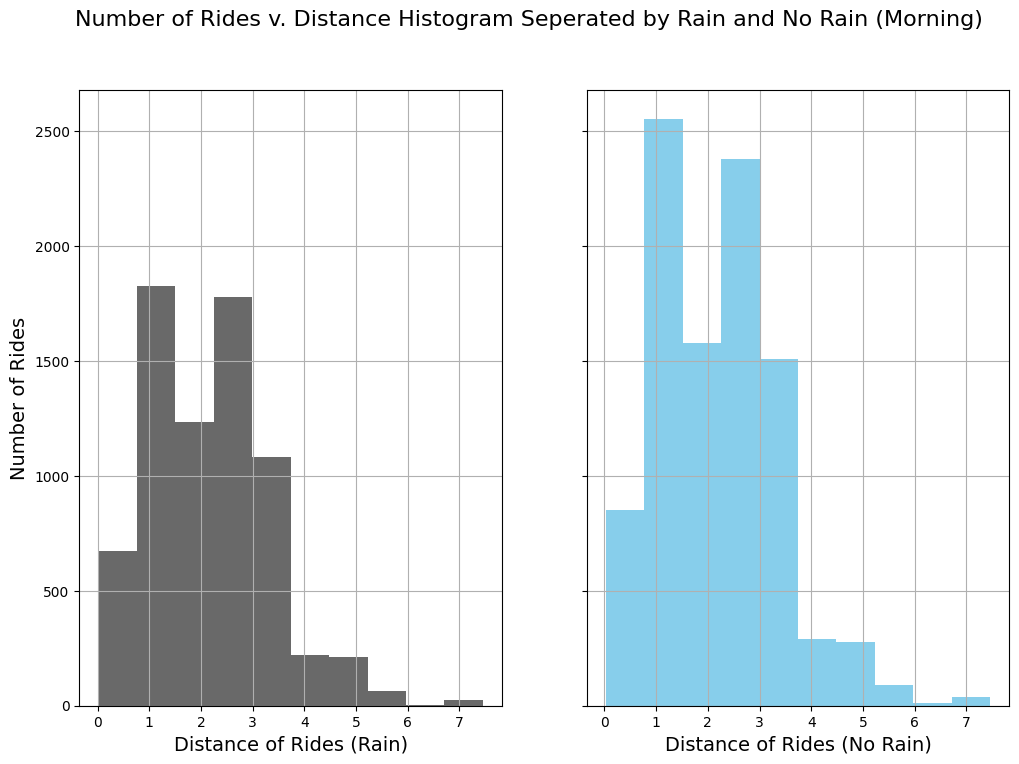

In [ ]:
fig, (ax1, ax2) = subplots(nrows=1,
                           ncols=2,
                           sharey=True,
                           figsize=(12, 8))

# Plot the rain histogram on the first subplot
dfrainmorning["distance"].hist(ax = ax1, color = "dimgray")
ax1.set_xlabel('Distance of Rides (Rain)', fontdict={'fontsize':14})
ax1.set_ylabel('Number of Rides', fontdict={'fontsize':14})

# Plot the no rain histogram on the second subplot
dfnorainmorning["distance"].hist(ax = ax2, color = "skyblue")
ax2.set_xlabel('Distance of Rides (No Rain)', fontdict={'fontsize':14})
fig.suptitle('Number of Rides v. Distance Histogram Seperated by Rain and No Rain (Morning)', fontsize=16)

# Ryan

Which weather condition has the single largest impact on surge multiplier?

The weather condition that serves as the best regressor on price is temperatureHigh and its r-squared value is 3.2630945058009786e-05


<Axes: title={'center': 'RSquared Value of Weather Regressors on Surge Multiplier (Lyft)'}, xlabel='regressor'>

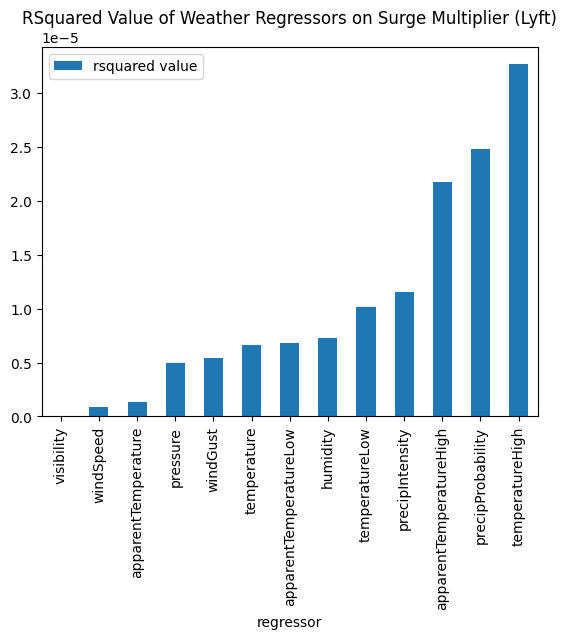

In [ ]:
#keep only weather-related columns
weather = df[['temperature', 'apparentTemperature', 'precipIntensity', 'precipProbability', \
              'humidity', 'windSpeed', 'windGust', 'visibility', 'temperatureHigh', 'temperatureLow', \
              'apparentTemperatureHigh', 'apparentTemperatureLow', 'pressure']]

#given that Uber has a constant surge multiplier in this dataset, we'll only focus on lyft's surge multiplier
mask = df['cab_type'] == 'Lyft'
weather = weather[mask]

#set up variables for holding the best r_squared value, the name of the best regressor, and a list of all regressors + their rsquared values
r_val = 0
best = ''
cols = []

#cycle through each of the regressors in weather
for col in weather:
  #set up the model with surge_multiplier as target
  predictors = "surge_multiplier ~ " + col
  y, X = dmatrices(predictors, data=df, return_type='dataframe')
  model = sm.OLS(y, X)
  result = model.fit()
  r = result.rsquared
  r_list = [col, r]
  cols.append(r_list)
  #determine if the present rsquared value is higher than the stored rsquared value
  if r > r_val:
    r_val = r
    best = col

print("The weather condition that serves as the best regressor on price is " + best + " and its " \
      "r-squared value is " + str(r_val))

#sort the columns from worst regressor to best regressor
cols.sort(key=lambda x: x[1])

#turn the cols array into a dataframe with the regressor and its respective rsquared value
r_df = pd.DataFrame(cols, columns = ['regressor', 'rsquared value'])

r_df.plot(x='regressor', title='RSquared Value of Weather Regressors on Surge Multiplier (Lyft)', kind='bar')









# Lisa

How do source-destination (A to B ride combinations) combos correlate with Cab type (whether lyft or uber preferred)? How do they correlate with the NAME within cab type (ie, does going from A to B result in more people selecting Uber XL?).


In [ ]:
# dfnew = df[['source', 'destination', 'cab_type', 'name']]
# df3 = dfnew.groupby(['source', 'destination', 'cab_type']).count()
# df4 = df3.unstack().sort_values(by=('name', 'Lyft'), ascending=False)
# #df4[('name','Lyft')].plot(figsize=(20,4),rot=90)
# df5 = df3.unstack().sort_values(by=('name', 'Uber'), ascending=False)


####Which combination of weather factors impact whether or not a ride will have a surge multiplier?

### LEGEND

**short_summary codes:**
>Overcast             1\
    Mostly Cloudy        2\
    Partly Cloudy        3\
    Clear                4\
    Light Rain           5\
    Rain                 6\
    Possible Drizzle     7\
    Foggy                8\
    Drizzle              9

**long_summary codes:**
 >Mostly cloudy throughout the day.                      1\
 Partly cloudy throughout the day.                      2\
 Light rain in the morning.                              3\
 Rain throughout the day.                                4\
 Rain until morning, starting again in the evening.      5\
 Light rain in the morning and overnight.                6\
 Foggy in the morning.                                   7\
 Light rain until evening.                               8\
 Overcast throughout the day.                             9\
 Possible drizzle in the morning.                         10\
 Rain in the morning and afternoon.                        11

 **cab_type codes:**
 >Uber 1\
 Lyft 2

**source codes:**
 >Theatre District           1\
Haymarket Square           2\
Beacon Hill                3\
West End                   4\
Financial District         5\
Northeastern University    6\
North Station              7\
North End                  8\
Back Bay                   9\
South Station              10\
Boston University          11\
Fenway                     12

**destination codes:**
 >Theatre District           1\
Haymarket Square           2\
Beacon Hill                3\
West End                   4\
Financial District         5\
Northeastern University    6\
North Station              7\
North End                  8\
Back Bay                   9\
South Station              10\
Boston University          11\
Fenway                     12

**name codes**
>UberXL          1\
UberPool        2\
Black SUV       3\
UberX           4\
WAV             5\
Black           6\
Lux Black XL    7\
Lux             8\
Shared          9\
Lyft XL         10\
Lux Black       11\
Lyft            12

In [ ]:
#Logistic Regression, with SURGE MULTIPLIER as target (yes: >1.0, no: =1.0) only for LYFTs.

#Create coded columns for categorical variables
#Encoding short_summary
ss_dict = {' Overcast ':1,' Mostly Cloudy ':2,' Partly Cloudy ':3, ' Clear ':4,' Light Rain ':5,' Rain ':6,' Possible Drizzle ':7,' Foggy ':8,' Drizzle ':9 }
dfnew = df.assign(ss_coded  = df.short_summary.map(ss_dict))

#The median surge multiplier for this dataset is 1, so surge_multiplier > 1 is the postive class, and surge_multiplier = 1 is the negative class.
dfnew['target'] = 0.0
dfnew['target'][dfnew['surge_multiplier'] > 1.0] = 1.0
# dfnew['target'] = 0.0
# dfnew['target'][dfnew['price']> 13.0] = 1.0

# #+ C(cabtype_coded)
dfnew = dfnew[dfnew['cab_type']=='Lyft']


df50 = dfnew[['hour', 'distance' ,'price' , 'longitude' , 'temperature','ss_coded' ,'precipIntensity','humidity','windGust', 'temperatureHigh',
'temperatureLow' ,'pressure','temperatureMin','temperatureMax','precipProbability', 'target']]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df50_scaled = scaler.fit_transform(df50)
dfscale= pd.DataFrame(df50_scaled, columns=['hour', 'distance' ,'price' , 'longitude' , 'temperature','ss_coded' ,'precipIntensity','humidity','windGust', 'temperatureHigh',
'temperatureLow' ,'pressure','temperatureMin','temperatureMax','precipProbability', 'target'])

# #Create formula for regression, and mark categorical variables with a C.
formula = 'target ~ 0 + hour  + distance + price ' + \
    ' + longitude + temperature   + C(ss_coded)  + precipIntensity  + humidity  +' +\
    'windGust  + temperatureHigh    + temperatureLow  ' + \
    ' + pressure  + temperatureMin + temperatureMax + precipProbability'

Y, X = dmatrices(formula, dfscale, return_type='dataframe')
y = Y['target'].values

#split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#fit logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X_train, y_train)

#find training accuracy
from sklearn import metrics
prediction_train = model.predict(X_train)
print("Training accuracy: " + str(metrics.accuracy_score(y_train, prediction_train)))

prediction = model.predict(X_test)
print("Testing accuracy: " + str(metrics.accuracy_score(y_test, prediction)))

#Baseline accuracy for surge on lyfts:
print('Baseline accuracy: ' + str(27408/(27408+2157)))

#Find feature Weights
weights = Series(model.coef_[0],
                 index=X.columns.values)
weights.sort_values()



Training accuracy: 0.9321575259724572
Testing accuracy: 0.9355129650507328
Baseline accuracy: 0.9270421106037544


distance             -1.930516
C(ss_coded)[0.625]   -0.162012
C(ss_coded)[0.5]     -0.116995
C(ss_coded)[0.25]    -0.049038
precipIntensity      -0.047379
C(ss_coded)[1.0]     -0.045557
humidity             -0.037377
temperatureMax       -0.015688
C(ss_coded)[0.0]      0.001641
temperatureMin        0.006081
precipProbability     0.007036
C(ss_coded)[0.875]    0.007649
hour                  0.021063
temperature           0.034338
temperatureLow        0.039452
longitude             0.066967
C(ss_coded)[0.125]    0.080468
C(ss_coded)[0.375]    0.117065
temperatureHigh       0.132244
pressure              0.143859
C(ss_coded)[0.75]     0.155939
windGust              0.166211
price                 8.937862
dtype: float64

Populating the interactive namespace from numpy and matplotlib
Training accuracy: 0.9259724571152452
Testing accuracy: 0.9295377677564826


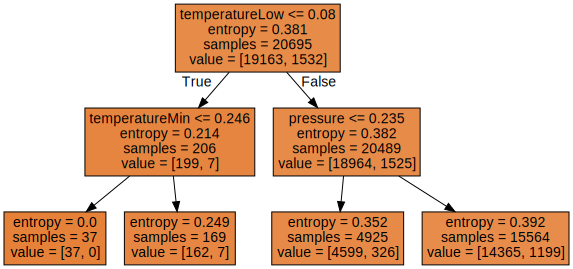

In [ ]:
#Decision Trees for Surge
import warnings
%pylab inline
warnings.filterwarnings('ignore')

df['target'] = 0.0
df['target'][df['surge_multiplier'] > 1.0] = 1.0
# dfnew['target'] = 0.0
# dfnew['target'][dfnew['price']> 13.0] = 1.0

# #+ C(cabtype_coded)
df = df[df['cab_type']=='Lyft']

df50 = df[['hour' ,'price' , 'longitude' , 'temperature', 'precipIntensity','humidity','windGust', 'temperatureHigh',
'temperatureLow' ,'pressure','temperatureMin','temperatureMax','precipProbability', 'target']]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df50_scaled = scaler.fit_transform(df50)
dfscale= pd.DataFrame(df50_scaled, columns=['hour' ,'price' , 'longitude' , 'temperature' ,'precipIntensity','humidity','windGust', 'temperatureHigh',
'temperatureLow' ,'pressure','temperatureMin','temperatureMax','precipProbability', 'target'])

#Create formula for regression, and mark categorical variables with a C.
formula = 'target ~ 0 + hour   ' + \
    ' + longitude + temperature    + precipIntensity + precipProbability + humidity  +' +\
    'windGust  + temperatureHigh    + temperatureLow   ' + \
    ' + pressure ' +\
    ' + temperatureMin + temperatureMax  '

Y, X = dmatrices(formula, dfscale, return_type='dataframe')
y = Y['target'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

from sklearn import tree
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)

result = model.fit(X_train, y_train)


#find training accuracy
from sklearn import metrics
prediction_train = model.predict(X_train)
print("Training accuracy: " + str(metrics.accuracy_score(y_train, prediction_train)))

prediction = model.predict(X_test)
print("Testing accuracy: " + str(metrics.accuracy_score(y_test, prediction)))

#todo: install graphviz to display this tree.

import graphviz
from graphviz import Source

graphviz.Source(tree.export_graphviz(model,
                                    out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True))


Which combination of weather factors most impacts ride price? (Use multiple regression)